In [39]:
%load_ext autoreload
%autoreload 2
    
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from Openseas_Methods import *
from pycoingecko import CoinGeckoAPI
from datetime import datetime,timedelta
import numpy as np
from scipy.stats import pearsonr
import pickle
import decision_tree as tree
from itertools import islice
from decision_tree import get_eth_price
import random


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
client = MongoClient()
db = client.NFTDB
collection_data = db.salesCollection
stats_collection = db.NFTStats
slug_collection = db.completedSlugs
combos = db.NFT
skip_list=['ens','base-introduced','fundrop-pass','gemesis','apecoin','dai-stablecoin','uniswap','1inch-token']

In [60]:
db.nftCombinations.find_one({})

{'_id': "('azukielementals', 'uniswap-v3-positions')", 'value': 195}

In [27]:
with open('combo_per.pkl','rb') as f:
    combo_perc = pickle.load(f)
features = tree.compute_graph_features(combo_perc,skip_list=skip_list)

Computing Average Edge Weights
Done Computing Average Edge Weights
Computing Centrality metrics


KeyboardInterrupt: 

In [3]:
with open('graph_features.pkl','rb') as f:
   features =  pickle.load(f)
flat_features = {}
for key,val in features.items():
    flat_features[key] = {k: v for d in val for k, v in d.items()}
df = pd.DataFrame.from_dict(flat_features, orient='index') 

In [4]:
df

,average_edge_weight_25,eigen_centrality,clustering_coeff,community_size,community_edge_size,community_average_edge_weight,CC_size_0.1,CC_edge_size_0.1,CC_average_edge_weight_0.1,CC_size_0.15000000000000002,...,CC_average_edge_weight_0.6000000000000002,CC_size_0.6500000000000001,CC_edge_size_0.6500000000000001,CC_average_edge_weight_0.6500000000000001,CC_size_0.7000000000000002,CC_edge_size_0.7000000000000002,CC_average_edge_weight_0.7000000000000002,CC_size_0.7500000000000002,CC_edge_size_0.7500000000000002,CC_average_edge_weight_0.7500000000000002
azukielementals,0.156842,1.274280e-04,0.014094,4777,121099,0.046253,3781.0,50455.0,0.053182,2252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
uniswap-v3-positions,0.110187,8.661593e-04,0.002768,4777,121099,0.046253,3781.0,50455.0,0.053182,2252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sproto-gremlins,0.094732,1.264946e-05,0.051791,118,2779,0.205875,3781.0,50455.0,0.053182,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
projectkaito,0.021092,4.402248e-05,0.026136,4777,121099,0.046253,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
projectyinyang,0.028990,1.743082e-04,0.015772,4777,121099,0.046253,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tribo-flameys,0.097104,3.439779e-06,0.000000,4777,121099,0.046253,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
drawn-apart,0.188854,9.098886e-06,0.000000,4777,121099,0.046253,3781.0,50455.0,0.053182,2252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ryokoclub,0.020566,4.743930e-07,0.000000,1732,308697,0.056471,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nakamigods,0.059510,2.796441e-05,0.000000,1732,308697,0.056471,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
records = stats_collection.find({})
for record in records:
    slug = record['slug']
    for key,value in islice(record.items(),54,None):
        if key!='slug':
            try:
                flat_features[slug][key] = value
            except:
                continue

In [141]:
x = []
y = []
for slug,_ in tqdm(flat_features.items()):
    sale_data = list(collection_data.find({'slug':slug,'timestamp':{'$regex':'2023'}}))
    # print(slug,len(milady_data))
    if len(sale_data)<100:
        continue
    sale_data = random.choices(sale_data,k=100)
    sale_prices = [x['total_price']*get_eth_price(x['timestamp']) for x in sale_data if x['timestamp']]
    eth_prices = [get_eth_price(x['timestamp']) for x in sale_data if x['timestamp']]
    p = eth_prices
    q = sale_prices
    # if slug == 'aopanda-party':
    #     plt.plot(np.unique(p), np.poly1d(np.polyfit(p, q, 1))(np.unique(p)))
    #     plt.scatter(p,q)
    corr = pearsonr(p,q)
    if corr.pvalue>0.05:
        continue
    flat_features[slug]['label'] = corr.statistic
    if corr.statistic>0.4:
        flat_features[slug]['label_disc'] = 4
    else:
        flat_features[slug]['label_disc'] = 3

100%|██████████████████████████████████████| 7357/7357 [00:10<00:00, 671.50it/s]


In [142]:
df = pd.DataFrame.from_dict(flat_features, orient='index') 

In [143]:
df['label']

azukielementals         0.212712
uniswap-v3-positions         NaN
sproto-gremlins        -0.403522
projectkaito                 NaN
projectyinyang               NaN
                          ...   
tribo-flameys                NaN
drawn-apart                  NaN
ryokoclub                    NaN
nakamigods                   NaN
bitaliens                    NaN
Name: label, Length: 7357, dtype: float64

In [144]:
filtered_df = df[~np.isnan(df['label'])]

In [145]:
filtered_df['label']

azukielementals     0.212712
sproto-gremlins    -0.403522
zanozaartbank       0.437185
doodles-official   -0.414140
dead-cat-check      0.114326
                      ...   
crea-genesis        0.027113
calvaria-nft        0.375797
qql-mint-pass      -0.178164
spacecrocos        -0.485570
nounsnug           -0.397022
Name: label, Length: 588, dtype: float64

In [146]:
labels = filtered_df['label']
features = filtered_df.drop(columns=['label'])

In [147]:
features

,average_edge_weight_25,eigen_centrality,clustering_coeff,community_size,community_edge_size,community_average_edge_weight,CC_size_0.1,CC_edge_size_0.1,CC_average_edge_weight_0.1,CC_size_0.15000000000000002,...,CC_average_edge_weight_0.6000000000000002,CC_size_0.6500000000000001,CC_edge_size_0.6500000000000001,CC_average_edge_weight_0.6500000000000001,CC_size_0.7000000000000002,CC_edge_size_0.7000000000000002,CC_average_edge_weight_0.7000000000000002,CC_size_0.7500000000000002,CC_edge_size_0.7500000000000002,CC_average_edge_weight_0.7500000000000002
azukielementals,0.156842,0.000127,0.014094,4777,121099,0.046253,3781.0,50455.0,0.053182,2252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sproto-gremlins,0.094732,0.000013,0.051791,118,2779,0.205875,3781.0,50455.0,0.053182,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zanozaartbank,0.197894,0.001003,0.024857,4777,121099,0.046253,3781.0,50455.0,0.053182,2252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
doodles-official,0.078899,0.000036,0.016017,4777,121099,0.046253,3781.0,50455.0,0.053182,2252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dead-cat-check,0.089023,0.002501,0.011066,4777,121099,0.046253,3781.0,50455.0,0.053182,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
crea-genesis,0.241335,0.000009,0.205512,4777,121099,0.046253,3781.0,50455.0,0.053182,2252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
calvaria-nft,0.087042,0.005109,0.058721,1732,308697,0.056471,3781.0,50455.0,0.053182,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
qql-mint-pass,0.224611,0.000002,0.000000,2,1,0.297794,3781.0,50455.0,0.053182,2252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
spacecrocos,0.241104,0.000464,0.163493,159,9130,0.147822,3781.0,50455.0,0.053182,2252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[Text(0.5443548387096774, 0.9166666666666666, 'community_size <= 138.5\nsquared_error = 0.106\nsamples = 588\nvalue = -0.072'),
 Text(0.23387096774193547, 0.75, 'average_edge_weight_25 <= 0.097\nsquared_error = 0.084\nsamples = 77\nvalue = 0.12'),
 Text(0.0967741935483871, 0.5833333333333334, 'average_edge_weight_25 <= 0.047\nsquared_error = 0.025\nsamples = 5\nvalue = -0.205'),
 Text(0.06451612903225806, 0.4166666666666667, 'squared_error = 0.0\nsamples = 1\nvalue = 0.071'),
 Text(0.12903225806451613, 0.4166666666666667, 'community_average_edge_weight <= 0.119\nsquared_error = 0.008\nsamples = 4\nvalue = -0.274'),
 Text(0.06451612903225806, 0.25, 'average_price <= 1.24\nsquared_error = 0.001\nsamples = 2\nvalue = -0.196'),
 Text(0.03225806451612903, 0.08333333333333333, 'squared_error = 0.053\nsamples = 1\nvalue = -0.231'),
 Text(0.0967741935483871, 0.08333333333333333, 'squared_error = -0.137\nsamples = 1\nvalue = -0.162'),
 Text(0.1935483870967742, 0.25, 'floor_price <= 0.799\nsquar

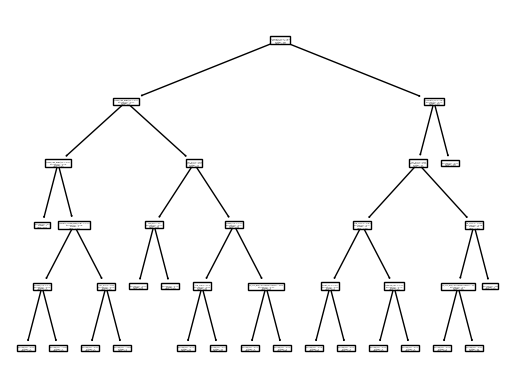

In [148]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree



# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=5)
feature_names = features.columns[:-1]
clf = regr_1.fit(features, labels)

tree.plot_tree(clf,feature_names=feature_names)


In [149]:
labels = filtered_df['label_disc']
features = filtered_df.drop(columns=['label','label_disc'])
features = filtered_df[['community_size']]

In [150]:
labels = [int(x) for x in labels]

In [151]:
print(len(labels))

588


'decision_tree_graph.png'

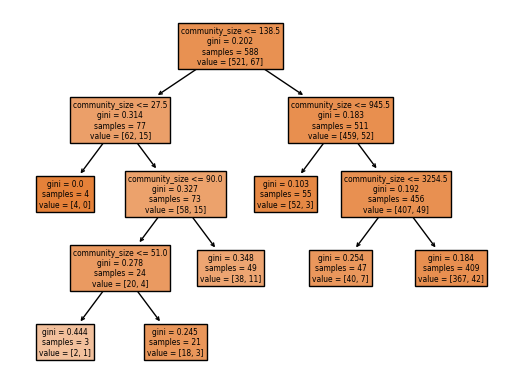

In [152]:
from sklearn.datasets import load_iris
from sklearn import tree
import graphviz
clf = tree.DecisionTreeClassifier(max_depth=6)
clf = clf.fit(features, labels)
feature_names = features.columns
tree.plot_tree(clf,feature_names=feature_names,filled=True)
dot_data = tree.export_graphviz(clf, 
                      feature_names=feature_names,    
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.format = 'png'  # You can change the format to 'pdf', 'png', 'jpg', etc.
graph.render("decision_tree_graph")

In [114]:
mask = (clf.apply(features)==26)
features[mask]

,average_edge_weight_25,eigen_centrality,clustering_coeff,community_size,community_edge_size,community_average_edge_weight,CC_size_0.1,CC_edge_size_0.1,CC_average_edge_weight_0.1,CC_size_0.15000000000000002,...,CC_average_edge_weight_0.6000000000000002,CC_size_0.6500000000000001,CC_edge_size_0.6500000000000001,CC_average_edge_weight_0.6500000000000001,CC_size_0.7000000000000002,CC_edge_size_0.7000000000000002,CC_average_edge_weight_0.7000000000000002,CC_size_0.7500000000000002,CC_edge_size_0.7500000000000002,CC_average_edge_weight_0.7500000000000002
the-mafia-animals-soldiers-,0.353640,0.000844,0.160206,159,9130,0.147822,3781.0,50455.0,0.053182,2252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
panlo-by-startph,0.278911,0.000769,0.130932,159,9130,0.147822,3781.0,50455.0,0.053182,2252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cnp-charm-official,0.260022,0.000742,0.123376,159,9130,0.147822,3781.0,50455.0,0.053182,2252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cnp-jobs,0.224402,0.000524,0.134044,159,9130,0.147822,3781.0,50455.0,0.053182,2252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shikibu-world,0.238036,0.000651,0.140110,159,9130,0.147822,3781.0,50455.0,0.053182,2252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cryptobabyanimals,0.237086,0.000382,0.186919,159,9130,0.147822,3781.0,50455.0,0.053182,2252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
startjpn-cryptoninja-world,0.311325,0.000844,0.127973,159,9130,0.147822,3781.0,50455.0,0.053182,2252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xana-penpenz-cryptoninja,0.284116,0.000658,0.145534,159,9130,0.147822,3781.0,50455.0,0.053182,2252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wafukugen,0.243454,0.000641,0.138221,159,9130,0.147822,3781.0,50455.0,0.053182,2252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aopanda-party,0.300244,0.000703,0.154538,159,9130,0.147822,3781.0,50455.0,0.053182,2252.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
np.unique(clf.apply(features),return_counts=True)

(array([ 4,  5,  6,  8, 11, 12, 14, 16, 18, 19, 23, 24, 26, 27, 28]),
 array([  1,  50,  63,   2,  30, 119,   1,  23,   1,  63,   1,   4,  20,
          2,   3]))